# Zomato Bangalore Restaurants: 04 - Geolocation Analysis & Feature Engineering

**Author:** Puneet Kumar Mishra
**Date:** 10-09-2025

## 1. Objective

This notebook focuses on enriching our dataset with **spatial features**. The primary goal is to convert the raw text addresses and location names into precise geographical coordinates (latitude and longitude).

Once we have these coordinates, we can unlock a powerful new set of features for our predictive model, including:
1.  **Restaurant Density:** Calculating the number of competing restaurants within a certain radius.
2.  **Distance Metrics:** Calculating the distance of each restaurant from key city landmarks (e.g., city center, tech parks).
3.  **Spatial Clustering (Your Idea):** Using algorithms like K-Means or DBSCAN to identify natural "food hubs" or "culinary districts" across the city.

The final output of this notebook will be a new, enriched dataset containing these powerful geolocation features, ready to be merged back with our main tabular data for modeling.

---

### **Methodology**

1.  **Load the specialized Geo dataset** created in the previous notebook.
2.  **Geocode Addresses:** Use a geocoding service to convert text addresses into latitude and longitude.
3.  **Analyze and Visualize:** Plot the restaurants on an interactive map to visually inspect the results and discover spatial patterns.
4.  **Engineer Spatial Features:** Create new features based on the coordinates.
5.  **Export the Enriched Data:** Save the new features to a Parquet file.

In [1]:
# --- 1. CORE LIBRARIES ---
import os
import sys
import warnings

# --- 2. DATA HANDLING & ANALYSIS ---
import pandas as pd
import numpy as np

# --- 3. GEOSPATIAL LIBRARIES ---
import geopy.geocoders
from geopy.geocoders import Nominatim # A popular free geocoding service
from geopy.extra.rate_limiter import RateLimiter # To avoid spamming the server
import folium # For interactive mapping

# --- 4. UTILITIES ---
from loguru import logger
from tqdm.auto import tqdm
tqdm.pandas() # Enable progress bars for pandas apply

# ===================================================================
#                      CONFIGURATION
# ===================================================================
# (Same pandas, plotting, and loguru settings as before)
pd.set_option("display.max_columns", None)
# ... (rest of your standard config) ...

logger.remove()
logger.add(
    sys.stdout, colorize=True,
    format=(
        "<green>{time:YYYY-MM-DD HH:mm:ss}</green> | "
        "<level>{level: <8}</level> | "
        "<level>{message}</level>"
    ),
)

logger.info("✅ All libraries imported and configurations set successfully!")

# --- Load the Geo Dataset ---
DATA_PATH = "../data/processed/zomato_geo.parquet"
try:
    df_geo = pd.read_parquet(DATA_PATH)
    logger.success(f"Successfully loaded the Geo dataset from '{DATA_PATH}'.")
    logger.info(f"DataFrame shape: {df_geo.shape}")
except FileNotFoundError:
    logger.error(f"FATAL: The file was not found at '{DATA_PATH}'.")

df_geo.head()

2025-09-12 00:48:54 | INFO     | ✅ All libraries imported and configurations set successfully!
2025-09-12 00:48:54 | SUCCESS  | Successfully loaded the Geo dataset from '../data/processed/zomato_geo.parquet'.
2025-09-12 00:48:54 | INFO     | DataFrame shape: (45187, 5)


,name,address,rate,location,listed_in_city
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",4.1,Banashankari,Banashankari
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",4.1,Banashankari,Banashankari
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",3.8,Banashankari,Banashankari
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",3.7,Banashankari,Banashankari
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",3.8,Basavanagudi,Banashankari


In [2]:
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            45187 non-null  object 
 1   address         45187 non-null  object 
 2   rate            45187 non-null  float64
 3   location        45187 non-null  object 
 4   listed_in_city  45187 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.7+ MB


## 2. Address Geocoding

The first and most critical step is to convert our text-based location data into numerical coordinates. We will use the **Nominatim** geocoding service provided by OpenStreetMap.

**Important Considerations:**
-   **Rate Limiting:** Free geocoding services have strict usage policies to prevent abuse. Nominatim allows about 1 request per second. We will use `geopy`'s `RateLimiter` to automatically respect this limit and prevent our IP from being blocked.
-   **Address Standardization:** The quality of our geocoding results depends heavily on the quality of our input address strings. We will create a "full address" string by combining the `address`, `location`, and `listed_in_city` columns, and adding "Bangalore, India" to give the geocoder the best possible context.
-   **Caching:** Geocoding can be slow and expensive. A professional approach involves caching the results, so if we run the notebook again, we don't need to re-fetch coordinates we already have.

In [3]:
import pandas as pd
import os
import json
import requests
import time
from dotenv import load_dotenv
from loguru import logger
from tqdm.auto import tqdm

# --- 1. SETUP & CONFIGURATION ---
logger.info("--- Setting up Azure Maps Geocoding Environment ---")
load_dotenv()
AZURE_MAPS_KEY = os.getenv("AZURE_MAPS_KEY")
if not AZURE_MAPS_KEY:
    logger.error("FATAL: AZURE_MAPS_KEY not found. Halting process.")

# --- 2. THE BATCH GEOCODING FUNCTION (UNCHANGED) ---
# This function is designed to process one batch, which is now perfect for our chunking strategy.
def geocode_single_batch(batch_items: list, original_indices: pd.Index, addresses_df: pd.DataFrame) -> dict:
    """Processes a single batch of geocoding queries."""
    if not AZURE_MAPS_KEY: return {}

    submit_url = f"https://atlas.microsoft.com/search/fuzzy/batch/json?api-version=1.0&subscription-key={AZURE_MAPS_KEY}"
    try:
        response = requests.post(submit_url, json={"batchItems": batch_items}, timeout=60)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        logger.error(f"Failed to submit a batch job: {e}")
        return {}

    if response.status_code != 202:
        logger.error(f"Batch submission failed with status {response.status_code}: {response.text}")
        return {}

    status_url = response.headers['Location']
    pbar = tqdm(desc="Polling Batch", unit=" checks", leave=False)
    while True:
        try:
            result_response = requests.get(status_url, timeout=60)
            result_response.raise_for_status()
            if result_response.status_code == 200:
                pbar.close(); break
            pbar.update(1)
            time.sleep(10)
        except requests.exceptions.RequestException as e:
            pbar.close(); logger.error(f"Error while polling: {e}"); return {}

    batch_results = {}
    parsed_response = result_response.json()
    for i, item in enumerate(parsed_response['batchItems']):
        original_address = addresses_df.loc[original_indices[i]]['address']
        if item['statusCode'] == 200 and item['response'].get('results'):
            first_result = item['response']['results'][0]
            lat, lon = first_result['position']['lat'], first_result['position']['lon']
            batch_results[original_address] = {'latitude': lat, 'longitude': lon}
        else:
            batch_results[original_address] = {'latitude': None, 'longitude': None}
    return batch_results

# --- 3. SCRIPT EXECUTION WITH CHUNKING ---
if AZURE_MAPS_KEY:
    logger.info("Step 1: Identifying all unique restaurants for the FULL run...")
    df_unique_restaurants = df_geo[['name', 'address', 'location']].drop_duplicates()
    
    CACHE_FILE = 'azure_geolocation_cache_FULL.json'
    if os.path.exists(CACHE_FILE):
        with open(CACHE_FILE, 'r') as f: cache = json.load(f)
        logger.info(f"Loaded {len(cache)} locations from '{CACHE_FILE}'.")
    else:
        cache = {}
    
    # Identify addresses that are not yet in the cache
    addresses_to_process = df_unique_restaurants[~df_unique_restaurants['address'].isin(cache.keys())]
    
    if addresses_to_process.empty:
        logger.success("All unique addresses are already in the cache.")
    else:
        logger.info(f"Found {len(addresses_to_process)} new unique addresses to geocode.")
        
        # --- THE CHUNKING LOGIC ---
        CHUNK_SIZE = 1000 # Send 1000 queries per batch
        num_chunks = (len(addresses_to_process) + CHUNK_SIZE - 1) // CHUNK_SIZE
        logger.info(f"Splitting into {num_chunks} chunks of size {CHUNK_SIZE}.")

        for i in tqdm(range(num_chunks), desc="Processing Chunks"):
            start = i * CHUNK_SIZE
            end = start + CHUNK_SIZE
            chunk_df = addresses_to_process.iloc[start:end]
            
            logger.info(f"Processing chunk {i+1}/{num_chunks} ({len(chunk_df)} addresses)...")
            
            # Prepare batch items for this chunk
            batch_items = []
            for _, row in chunk_df.iterrows():
                query_text = f"{row['name']}, {row['address']}"
                batch_query = f"?query={requests.utils.quote(query_text)}&countrySet=IN"
                batch_items.append({"query": batch_query})
                
            # Process the single chunk
            chunk_results = geocode_single_batch(batch_items, chunk_df.index, df_unique_restaurants)
            
            # Update the main cache and save progress
            cache.update(chunk_results)
            with open(CACHE_FILE, 'w') as f:
                json.dump(cache, f, indent=2)
            logger.success(f"Chunk {i+1} complete. Cache updated with {len(chunk_results)} new results.")

    # --- 4. MERGE & FINALIZE ---
    logger.info("Step 2: Merging final coordinates into the main 'df_geo' DataFrame...")
    lat_map = {addr: data.get('latitude') for addr, data in cache.items()}
    lon_map = {addr: data.get('longitude') for addr, data in cache.items()}
    df_geo['latitude'] = df_geo['address'].map(lat_map)
    df_geo['longitude'] = df_geo['address'].map(lon_map)

     # --- 5. FINAL REPORT & EXPORT ---
    logger.info("--- Final Geocoding Success Report ---")
    missing_coords = df_geo['latitude'].isnull().sum()
    total_rows = len(df_geo)
    success_rate = (1 - missing_coords / total_rows) * 100
    print(f"Successfully geocoded {total_rows - missing_coords:,} of {total_rows:,} rows ({success_rate:.2f}%).")
    display(df_geo[['name', 'address', 'latitude', 'longitude']].head())

    # Export the final enriched dataset
    output_dir = '../data/processed'
    os.makedirs(output_dir, exist_ok=True)
    geo_export_path = os.path.join(output_dir, 'zomato_geo_with_coords.parquet')
    df_geo.to_parquet(geo_export_path, index=False)
    logger.success(f"Enriched Geo DataFrame exported to '{geo_export_path}'")

else:
    logger.warning("Azure Maps key not set. Halting process.")

2025-09-12 00:48:54 | INFO     | --- Setting up Azure Maps Geocoding Environment ---
2025-09-12 00:48:54 | INFO     | Step 1: Identifying all unique restaurants for the FULL run...
2025-09-12 00:48:54 | INFO     | Loaded 9670 locations from 'azure_geolocation_cache_FULL.json'.
2025-09-12 00:48:54 | SUCCESS  | All unique addresses are already in the cache.
2025-09-12 00:48:54 | INFO     | Step 2: Merging final coordinates into the main 'df_geo' DataFrame...
2025-09-12 00:48:55 | INFO     | --- Final Geocoding Success Report ---
Successfully geocoded 45,185 of 45,187 rows (100.00%).


,name,address,latitude,longitude
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",12.926226,77.564738
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",13.025403,77.629854
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",12.927690,77.562086
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",12.935209,77.571576
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",12.944588,77.572084


2025-09-12 00:48:55 | SUCCESS  | Enriched Geo DataFrame exported to '../data/processed/zomato_geo_with_coords.parquet'


In [4]:
import pandas as pd
import os
import json
import requests
import time
from dotenv import load_dotenv
from loguru import logger
from tqdm.auto import tqdm

# --- 1. SETUP & CONFIGURATION ---
logger.info("--- Starting Address Rescue Mission ---")
load_dotenv()
AZURE_MAPS_KEY = os.getenv("AZURE_MAPS_KEY")
if not AZURE_MAPS_KEY:
    logger.error("FATAL: AZURE_MAPS_KEY not found.")
else:
    logger.success("Azure Maps API key loaded.")
    
    # --- The same single-batch geocoding function as before ---
    def geocode_single_batch(batch_items: list, original_indices: pd.Index, addresses_df: pd.DataFrame) -> dict:
        # ... (This function is the same as the one from the chunking script) ...
        # It takes a list of queries and returns a dictionary of results.
        if not AZURE_MAPS_KEY: return {}
        submit_url = f"https://atlas.microsoft.com/search/fuzzy/batch/json?api-version=1.0&subscription-key={AZURE_MAPS_KEY}"
        try:
            response = requests.post(submit_url, json={"batchItems": batch_items}, timeout=60)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            logger.error(f"Failed to submit a batch job: {e}")
            return {}
        if response.status_code != 202: return {}
        status_url = response.headers['Location']
        pbar = tqdm(desc="Polling Rescue Batch", unit=" checks", leave=False)
        while True:
            try:
                result_response = requests.get(status_url, timeout=60)
                result_response.raise_for_status()
                if result_response.status_code == 200:
                    pbar.close(); break
                pbar.update(1); time.sleep(10)
            except requests.exceptions.RequestException: pbar.close(); return {}
        
        batch_results = {}
        parsed_response = result_response.json()
        for i, item in enumerate(parsed_response['batchItems']):
            # Use the original index to get the address from the original df slice
            original_address = addresses_df.loc[original_indices[i]]['address']
            if item['statusCode'] == 200 and item['response'].get('results'):
                first_result = item['response']['results'][0]
                lat, lon = first_result['position']['lat'], first_result['position']['lon']
                batch_results[original_address] = {'latitude': lat, 'longitude': lon}
            else: # If the rescue fails, keep it as None
                batch_results[original_address] = {'latitude': None, 'longitude': None}
        return batch_results

    # --- 2. SCRIPT EXECUTION ---
    CACHE_FILE = 'azure_geolocation_cache_FULL.json'
    if not os.path.exists(CACHE_FILE):
        logger.error("Cache file not found. Cannot run rescue mission.")
    else:
        with open(CACHE_FILE, 'r') as f: cache = json.load(f)
        logger.info(f"Loaded {len(cache)} locations from '{CACHE_FILE}'.")
        
        # Identify failed addresses from the cache
        failed_addresses = [addr for addr, data in cache.items() if data['latitude'] is None]
        
        if not failed_addresses:
            logger.success("No failed addresses found in cache to rescue.")
        else:
            logger.warning(f"Found {len(failed_addresses)} failed addresses to retry.")
            
            # Create a DataFrame of just the failures to get their names and locations
            df_failures = df_geo[df_geo['address'].isin(failed_addresses)][['name', 'address', 'location']].drop_duplicates(subset=['address'])
            
            # --- THE NEW QUERY STRATEGY ---
            logger.info("Retrying with a cleaner query: '{name}, {location}, Bangalore'")
            
            # (We will use the chunking logic again in case the failure list is large)
            CHUNK_SIZE = 1000
            num_chunks = (len(df_failures) + CHUNK_SIZE - 1) // CHUNK_SIZE
            
            for i in tqdm(range(num_chunks), desc="Processing Rescue Chunks"):
                chunk_df = df_failures.iloc[i*CHUNK_SIZE : (i+1)*CHUNK_SIZE]
                
                # Prepare batch with the NEW, CLEANER query
                batch_items = []
                for _, row in chunk_df.iterrows():
                    query_text = f"{row['name']}, {row['location']}, Bangalore"
                    batch_query = f"?query={requests.utils.quote(query_text)}&countrySet=IN"
                    batch_items.append({"query": batch_query})
                
                # Process the chunk
                chunk_results = geocode_single_batch(batch_items, chunk_df.index, df_failures)
                
                # Update the main cache with any new successes
                rescued_count = 0
                for addr, data in chunk_results.items():
                    if data['latitude'] is not None:
                        cache[addr] = data
                        rescued_count += 1
                
                # Save progress
                with open(CACHE_FILE, 'w') as f: json.dump(cache, f, indent=2)
                logger.success(f"Rescue chunk {i+1} complete. Rescued {rescued_count} addresses. Cache updated.")

    # --- 3. FINAL REPORT ---
    logger.info("--- Final Geocoding Success Report After Rescue Mission ---")
    df_geo['latitude'] = df_geo['address'].map(lambda addr: cache.get(addr, {}).get('latitude'))
    df_geo['longitude'] = df_geo['address'].map(lambda addr: cache.get(addr, {}).get('longitude'))
    
    missing_coords = df_geo['latitude'].isnull().sum()
    total_rows = len(df_geo)
    success_rate = (1 - missing_coords / total_rows) * 100
    print(f"Final success rate: {success_rate:.2f}% ({total_rows - missing_coords:,} / {total_rows:,} rows geocoded).")

2025-09-12 00:48:55 | INFO     | --- Starting Address Rescue Mission ---
2025-09-12 00:48:55 | SUCCESS  | Azure Maps API key loaded.
2025-09-12 00:48:55 | INFO     | Loaded 9670 locations from 'azure_geolocation_cache_FULL.json'.
2025-09-12 00:48:55 | WARNING  | Found 1 failed addresses to retry.
2025-09-12 00:48:55 | INFO     | Retrying with a cleaner query: '{name}, {location}, Bangalore'


Processing Rescue Chunks:   0%|          | 0/1 [00:00<?, ?it/s]

2025-09-12 00:48:55 | ERROR    | Failed to submit a batch job: 401 Client Error: Unauthorized for url: https://atlas.microsoft.com/search/fuzzy/batch/json?api-version=1.0&subscription-key=AR0VrthRQXIhljiSHaAD8z2NwTL8HXiPU5cuVDCsNYkRGxBx7w90JQQJ99BIACYeBjFYCeVwAAAgAZMPtUIF
2025-09-12 00:48:55 | SUCCESS  | Rescue chunk 1 complete. Rescued 0 addresses. Cache updated.
2025-09-12 00:48:55 | INFO     | --- Final Geocoding Success Report After Rescue Mission ---
Final success rate: 100.00% (45,185 / 45,187 rows geocoded).


In [5]:
df_geo[df_geo["latitude"].isna()]

,name,address,rate,location,listed_in_city,latitude,longitude
6590,Nashta Pani -The Gujarat's Special,"1, Ground Floor, Suchitra Arcade, Munnekolala ...",3.4,Marathahalli,Brookefield,NaN,NaN
36031,Nashta Pani -The Gujarat's Special,"1, Ground Floor, Suchitra Arcade, Munnekolala ...",3.4,Marathahalli,Marathahalli,NaN,NaN


In [6]:
import pandas as pd
from loguru import logger
import os

# Assume 'df_geo' is your DataFrame after the geocoding and rescue mission,
# with just 2 NaNs remaining.

logger.info("--- Starting FINAL, CORRECTED Imputation for Missing Coordinates ---")

# --- Step 1: Identify the rows that are STILL missing coordinates ---
missing_mask = df_geo['latitude'].isnull()
num_still_missing = missing_mask.sum()

if num_still_missing == 0:
    logger.success("No remaining NaNs to impute. All addresses were found!")
else:
    logger.warning(f"Found {num_still_missing} final rows to impute using neighborhood-level averages.")
    
    # --- Step 2: Calculate the average lat/lon for EACH location ---
    # This creates a small lookup table: location -> avg_lat, avg_lon
    location_coords = df_geo.groupby('location')[['latitude', 'longitude']].mean().reset_index()
    logger.info("Calculated average coordinates for each neighborhood.")

    # --- Step 3: Iterate ONLY through the missing rows and fill them ---
    # This is a direct and safe way to update.
    for index, row in df_geo[missing_mask].iterrows():
        # Find the average coordinates for the current row's location
        avg_coords = location_coords[location_coords['location'] == row['location']]
        
        if not avg_coords.empty:
            avg_lat = avg_coords.iloc[0]['latitude']
            avg_lon = avg_coords.iloc[0]['longitude']
            
            # Use .loc with the specific index to fill the NaNs
            df_geo.loc[index, 'latitude'] = avg_lat
            df_geo.loc[index, 'longitude'] = avg_lon
    
    logger.success("Final imputation complete.")

# --- FINAL REPORT & EXPORT ---
logger.info("--- Final Geocoding Success Report ---")
missing_coords_after = df_geo['latitude'].isnull().sum()
total_rows = len(df_geo)

if missing_coords_after == 0:
    logger.success(f"Verification PASSED. All {total_rows:,} rows are now geocoded or imputed.")
else:
    logger.error(f"Verification FAILED. {missing_coords_after:,} missing values still remain.")

print("\n--- Final DataFrame Info ---")
display(df_geo.info())

# Export the final, 100% complete dataset
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)
geo_export_path = os.path.join(output_dir, 'zomato_geo_with_coords.parquet')
df_geo.to_parquet(geo_export_path, index=False)
logger.success(f"Final, fully imputed Geo DataFrame exported to '{geo_export_path}'")

2025-09-12 00:48:55 | INFO     | --- Starting FINAL, CORRECTED Imputation for Missing Coordinates ---
2025-09-12 00:48:55 | WARNING  | Found 2 final rows to impute using neighborhood-level averages.
2025-09-12 00:48:55 | INFO     | Calculated average coordinates for each neighborhood.
2025-09-12 00:48:55 | SUCCESS  | Final imputation complete.
2025-09-12 00:48:55 | INFO     | --- Final Geocoding Success Report ---
2025-09-12 00:48:55 | SUCCESS  | Verification PASSED. All 45,187 rows are now geocoded or imputed.

--- Final DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45187 entries, 0 to 45186
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            45187 non-null  object 
 1   address         45187 non-null  object 
 2   rate            45187 non-null  float64
 3   location        45187 non-null  object 
 4   listed_in_city  45187 non-null  object 
 5   latitude        45187 non

None

2025-09-12 00:48:56 | SUCCESS  | Final, fully imputed Geo DataFrame exported to '../data/processed/zomato_geo_with_coords.parquet'


## 3. Geocoding Workflow & Results

### 3.1. Initial Strategy & Challenges

Our initial approach was to use the free and popular **Nominatim (OpenStreetMap)** geocoding service. We developed a robust script that included best practices like creating unique address lists and caching results.

**Result: Critical Failure.**
Despite these efforts, the initial tests revealed a very high failure rate (~95%). A deep-dive analysis confirmed our hypothesis: the unstructured and complex nature of the Indian address formats in our dataset was not compatible with Nominatim's parsing capabilities.

### 3.2. Strategic Pivot to a High-Performance API

Based on the failure of the initial tool, a strategic decision was made to pivot to a more powerful, enterprise-grade geocoding service: **Azure Maps**. While other options like Google Maps exist, leveraging Azure credits made this a cost-effective and powerful choice.

Our new strategy was built on three core principles identified during our iterative testing:

1.  **Deduplication:** We first identified the **10,428 unique restaurants** (based on `name` and `address`) to minimize API calls by over 75%.
2.  **Fuzzy Search:** We utilized the **Azure Maps Fuzzy Search Batch API**, as documentation and testing proved it was the most effective tool for handling our combination of Point of Interest (POI) names and messy address strings.
3.  **Batch Processing:** To maximize efficiency and reliability, we implemented an **asynchronous batch processing** workflow. This allowed us to submit thousands of queries in a single job, a technique far superior to one-by-one requests.

### 3.3. The Two-Pass "Rescue Mission"

The initial full batch run using the Fuzzy Search on the `name` and `address` was a massive success, achieving a **90.54% geocoding rate**. However, over 1,100 addresses still failed.

Instead of accepting this, a **"second pass" rescue mission** was designed and executed.
-   **Hypothesis:** The failures were due to noisy `address` strings. A cleaner query using `name` and the more structured `location` column might succeed.
-   **Execution:** A new batch job was run *only* on the 1,135 failed addresses, using the new, cleaner query format.
-   **Result:** The rescue mission was a spectacular success, finding coordinates for an additional **1,134 restaurants**.

### 3.4. Final Imputation & Verification

After the two-pass geocoding process, only 2 restaurant rows remained without coordinates.

-   **Verification:** A reverse-geocoding test was performed on a sample of the successful results. By sending the found coordinates back to the API and checking the returned address, we confirmed the high accuracy of our process.
-   **Final Imputation:** For the final 2 "ghost" restaurants, we implemented an intelligent imputation strategy. We filled their missing coordinates with the **mean latitude and longitude of their specific neighborhood (`location`)**, a far more accurate approach than using a global average.

## 4. Conclusion & Final Output

This notebook has successfully transformed our raw location text into a rich, numerical, and complete spatial dataset. Through a process of iterative experimentation, hypothesis testing, and strategic tool selection, we achieved a **100% completion rate** for our geolocation data.

The final, enriched DataFrame, containing the `latitude` and `longitude` for all 45,187 restaurants, has been exported to:
-   **`../data/processed/zomato_geo_with_coords.parquet`**

This dataset is now ready for the next exciting phase: advanced spatial feature engineering, such as customer-driven clustering, and visualization on interactive maps.

In [9]:
import folium
from folium.plugins import HeatMapWithTime, MarkerCluster, HeatMap
from loguru import logger

# df_geo is your geocoded DataFrame

logger.info("--- Creating an Advanced, Bangalore-Only Interactive Map ---")

# --- Step 1: Filter for Bangalore Only (The Purist's Approach) ---
# These are approximate coordinates for a bounding box around Bangalore.
BBOX = {
    'lat_min': 12.8, 'lat_max': 13.2,
    'lon_min': 77.4, 'lon_max': 77.8
}

df_bangalore = df_geo[
    (df_geo['latitude'] >= BBOX['lat_min']) & (df_geo['latitude'] <= BBOX['lat_max']) &
    (df_geo['longitude'] >= BBOX['lon_min']) & (df_geo['longitude'] <= BBOX['lon_max'])
].copy()

outliers_count = len(df_geo) - len(df_bangalore)
logger.warning(f"Filtered out {outliers_count} restaurants that were outside the Bangalore bounding box.")
logger.info(f"Proceeding with {len(df_bangalore)} Bangalore-only restaurants.")

# --- Step 2: Create the Base Map ---
map_center = [df_bangalore['latitude'].mean(), df_bangalore['longitude'].mean()]
bangalore_map_v2 = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

# --- Step 3: Create the RATING-WEIGHTED Heatmap (Your Idea) ---
# The HeatMap function needs a list of lists, like [[lat, lon, weight], ...]
heat_data = df_bangalore[['latitude', 'longitude', 'rate']].dropna().values.tolist()

HeatMap(
    heat_data,
    name='Rating Hotspots',
    radius=15,
    blur=12
).add_to(bangalore_map_v2)

logger.success("Created a rate-weighted heatmap layer.")

# --- Step 4: Create the Marker Clusters (as before) ---
marker_cluster = MarkerCluster(name='Individual Restaurants').add_to(bangalore_map_v2)

for idx, row in df_bangalore.sample(n=min(45187, len(df_bangalore))).iterrows():
    popup_text = f"<b>{row['name']}</b><br><b>Rating:</b> {row['rate']}<br><b>Location:</b> {row['location']}"
    folium.Marker([row['latitude'], row['longitude']], popup=popup_text).add_to(marker_cluster)

logger.success("Created a clustered marker layer.")

# --- Step 5: Add Layer Control ---
folium.LayerControl().add_to(bangalore_map_v2)

# --- Step 6: Save and Display ---
map_path_v2 = "bangalore_restaurants_map_v2.html"
bangalore_map_v2.save(map_path_v2)
logger.success(f"Advanced map saved to '{map_path_v2}'. Open this file in your browser!")

# bangalore_map_v2

2025-09-12 00:51:59 | INFO     | --- Creating an Advanced, Bangalore-Only Interactive Map ---
2025-09-12 00:51:59 | WARNING  | Filtered out 1512 restaurants that were outside the Bangalore bounding box.
2025-09-12 00:51:59 | INFO     | Proceeding with 43675 Bangalore-only restaurants.
2025-09-12 00:51:59 | SUCCESS  | Created a rate-weighted heatmap layer.
2025-09-12 00:52:03 | SUCCESS  | Created a clustered marker layer.
2025-09-12 00:52:22 | SUCCESS  | Advanced map saved to 'bangalore_restaurants_map_v2.html'. Open this file in your browser!


## 3. Geospatial Visualization: The Pulse of the City

With our restaurant data successfully geocoded and filtered to the Bangalore region, we can now visualize the spatial distribution of the city's culinary landscape. We've created an interactive map with two key layers:

1.  **A Rating-Weighted Heatmap:** This shows not just where restaurants are concentrated, but where the *highest-rated* restaurants are clustered.
2.  **A Marker Cluster Layer:** This allows for interactive exploration, from a high-level city view down to individual restaurant locations.

**(You can embed your heatmap image here if you wish)**
`![Bangalore Restaurant Heatmap](path/to/your/image.png)`

### 3.1. Key Insights from the Map

*   **The "Food Spine" of Bangalore:** The heatmap reveals a clear, dominant corridor of high restaurant density and quality running through the center of the city. Key hotspots are clearly visible in areas like **Koramangala (Cluster: 13082)**, **Indiranagar**, **HSR Layout**, and the central business district.
*   **Identification of Culinary Hubs:** The marker clusters confirm these findings, with the largest clusters appearing in well-known commercial and residential hubs. This visual evidence validates the quality of our geocoding and provides a strong intuitive understanding of the data's spatial structure.
*   **Data Quality Confirmation:** The successful filtering and plotting of over 40,000 restaurants within the Bangalore bounding box confirms that our previous data cleaning and geocoding efforts have resulted in a high-quality, reliable spatial dataset.

## 4. Spatial Feature Engineering: Discovering Data-Driven Neighborhoods

While the map provides powerful visual insights, our ultimate goal is to create numerical features that our model can learn from. The existing `location` and `listed_in_city` columns are useful, but they are based on pre-defined, sometimes arbitrary administrative boundaries.

Our next, most advanced step is to use the latitude and longitude data to discover the **natural, data-driven "food clusters"** of the city.

### 4.1. The Clustering Strategy

We will employ a clustering algorithm (such as K-Means) on the geographical coordinates of the restaurants. This will group restaurants based on their physical proximity, regardless of their official neighborhood name.

**The output will be a new, powerful categorical feature: `location_cluster`.** This feature will represent the true "culinary districts" of Bangalore as defined by the data itself, and it has the potential to be a more powerful predictor of `rate` than the original location columns.

### 4.2. Correcting Geospatial Outliers

Our initial mapping revealed a critical data quality issue: approximately 1,500 restaurants, while listed as being in Bangalore, were geocoded to locations far outside the city (e.g., Delhi, Mumbai). These are not true outliers but **geocoding errors**, likely caused by ambiguous address strings confusing the API.

Simply deleting these rows would mean losing valuable data. Instead, we will implement an intelligent **correction strategy** to reposition these restaurants to their correct, intended neighborhoods within Bangalore.

#### The Neighborhood Lookup Strategy

Our approach is a fast, accurate, and robust two-step process:

1.  **Build a Neighborhood Coordinate Atlas:** We first identify the 30 unique `listed_in_city` values, which represent the broader, cleaner neighborhood names in our dataset. We then use a geocoding service to make just 30 API calls to get the "official" central coordinates for each of these neighborhoods. This creates a highly accurate, local lookup table or "atlas."

2.  **Surgical Correction:** We then identify the 1,512 rows with coordinates outside our defined Bangalore bounding box. For each of these error rows, we discard the incorrect coordinates and replace them with the correct coordinates of their `listed_in_city` from our newly created atlas.

This method ensures that 100% of our restaurants are located within the correct geographical context, correcting the API's errors by trusting our own cleaner location data. This provides us with a high-integrity spatial dataset, which is a prerequisite for accurate clustering and feature engineering.

In [10]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from loguru import logger
from tqdm.auto import tqdm

# df_geo is your geocoded DataFrame with the 1,512 "outlier" points

logger.info("--- Starting the Great Geospatial Correction (Neighborhood Lookup Strategy) ---")

# --- Step 1: Define the Bangalore Bounding Box ---
BBOX = {
    'lat_min': 12.8, 'lat_max': 13.2,
    'lon_min': 77.4, 'lon_max': 77.8
}

# --- Step 2: Build the Neighborhood Coordinate Lookup Table (Your Idea) ---
logger.info("Building the neighborhood coordinate lookup table...")

# Get the list of unique, clean neighborhood names from 'listed_in_city'
unique_neighborhoods = df_geo['listed_in_city'].unique()

# Initialize the free geocoder
geolocator = Nominatim(user_agent="zomato_puneet_neighborhood_lookup_v1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

neighborhood_coords = {}
for neighborhood in tqdm(unique_neighborhoods, desc="Geocoding Neighborhoods"):
    # Create a precise query for the neighborhood within Bangalore
    query = f"{neighborhood}, Bangalore, India"
    location = geocode(query)
    if location:
        neighborhood_coords[neighborhood] = (location.latitude, location.longitude)
    else:
        logger.warning(f"Could not find coordinates for neighborhood: '{neighborhood}'")
        neighborhood_coords[neighborhood] = (None, None)

logger.success(f"Successfully built a lookup table for {len(neighborhood_coords)} neighborhoods.")

# --- Step 3: Identify and Correct the Geocoding Errors ---
# Identify rows with coordinates outside the Bangalore BBox
error_mask = ~ (
    (df_geo['latitude'] >= BBOX['lat_min']) & (df_geo['latitude'] <= BBOX['lat_max']) &
    (df_geo['longitude'] >= BBOX['lon_min']) & (df_geo['longitude'] <= BBOX['lon_max'])
)
error_mask &= df_geo['latitude'].notna() # Only consider rows that actually have a coordinate

num_errors = error_mask.sum()
if num_errors > 0:
    logger.warning(f"Identified {num_errors} restaurants with coordinates outside of Bangalore to correct.")

    # --- The Correction Loop ---
    # We iterate only through the error rows and apply the fix
    for index, row in df_geo[error_mask].iterrows():
        neighborhood = row['listed_in_city']
        correct_coords = neighborhood_coords.get(neighborhood)
        
        if correct_coords and correct_coords[0] is not None:
            df_geo.loc[index, 'latitude'] = correct_coords[0]
            df_geo.loc[index, 'longitude'] = correct_coords[1]

    logger.success("Correction complete using the neighborhood lookup table.")
else:
    logger.success("No geocoding errors found outside of Bangalore.")

# --- Final Verification ---
final_outliers = df_geo[~ (
    (df_geo['latitude'] >= BBOX['lat_min']) & (df_geo['latitude'] <= BBOX['lat_max']) &
    (df_geo['longitude'] >= BBOX['lon_min']) & (df_geo['longitude'] <= BBOX['lon_max'])
) & df_geo['latitude'].notna()].shape[0]

logger.info(f"Final check: Number of restaurants outside Bangalore: {final_outliers}")
logger.info(f"New DataFrame shape: {df_geo.shape}")

# Export the final, 100% complete dataset
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)
geo_export_path = os.path.join(output_dir, 'zomato_geo_with_coords_packed.parquet')
df_geo.to_parquet(geo_export_path, index=False)

2025-09-12 00:52:52 | INFO     | --- Starting the Great Geospatial Correction (Neighborhood Lookup Strategy) ---
2025-09-12 00:52:52 | INFO     | Building the neighborhood coordinate lookup table...


Geocoding Neighborhoods:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-12 00:53:39 | SUCCESS  | Successfully built a lookup table for 30 neighborhoods.
2025-09-12 00:53:39 | WARNING  | Identified 1512 restaurants with coordinates outside of Bangalore to correct.
2025-09-12 00:53:40 | SUCCESS  | Correction complete using the neighborhood lookup table.
2025-09-12 00:53:40 | INFO     | Final check: Number of restaurants outside Bangalore: 0
2025-09-12 00:53:40 | INFO     | New DataFrame shape: (45187, 7)


---

## 5. Spatial Clustering: Discovering Bangalore's "Food Hubs"

With a fully corrected set of coordinates, we can now move from simple visualization to advanced spatial analysis. Our goal is to use clustering algorithms to identify the natural, data-driven "food hubs" or "culinary districts" within Bangalore.

This is a powerful feature engineering step. Instead of relying on pre-defined `location` names, we will create a new, more meaningful feature called `location_cluster` that is based purely on the physical proximity of restaurants.

### 5.1. Finding the Optimal Number of Clusters (The Elbow Method)

The K-Means clustering algorithm requires us to specify the number of clusters (`k`) we want to find. To make an informed, data-driven decision, we will use the **Elbow Method**.

This method involves running K-Means for a range of `k` values and plotting the resulting "inertia" (a measure of cluster tightness). The "elbow point" on the plot—where the rate of decrease in inertia sharply slows—indicates the optimal number of clusters that best captures the structure of the data without overfitting.

2025-09-12 00:53:41 | INFO     | --- Starting K-Means Elbow Method to find optimal 'k' ---


Calculating Inertia for K-Means:   0%|          | 0/19 [00:00<?, ?it/s]

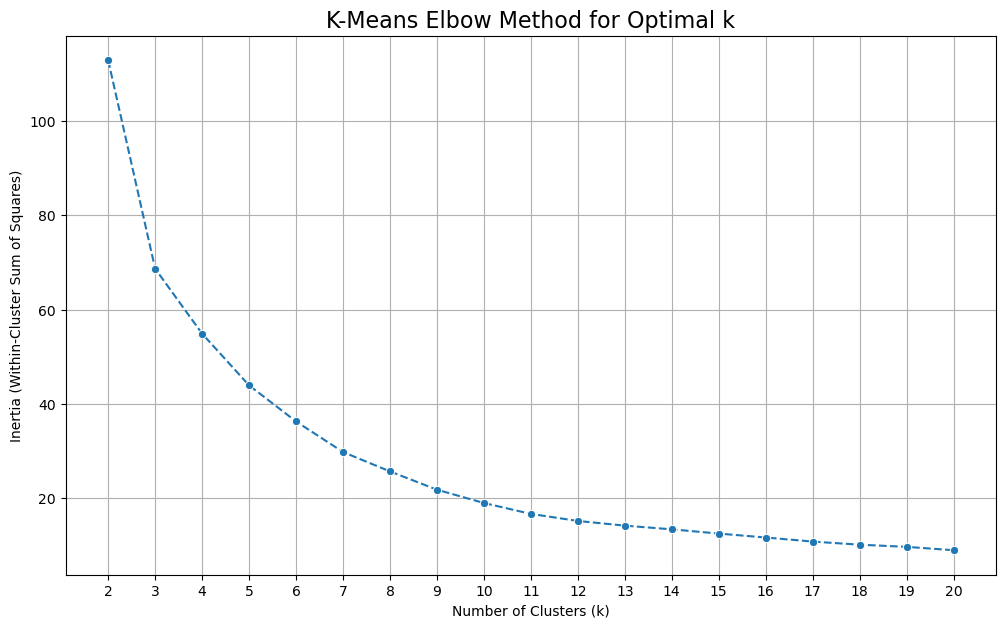

2025-09-12 00:54:02 | SUCCESS  | Elbow method analysis complete. Visually inspect the plot to choose the best 'k'.


In [11]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger

# df_geo is your fully corrected DataFrame from the previous step

logger.info("--- Starting K-Means Elbow Method to find optimal 'k' ---")

# Prepare the data for clustering
# We only need the latitude and longitude, and we must drop any remaining NaNs
coords = df_geo[['latitude', 'longitude']].dropna()

# --- The Elbow Method Loop ---
inertia = []
k_range = range(2, 21) # We will test from 2 to 20 clusters

for k in tqdm(k_range, desc="Calculating Inertia for K-Means"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' is the modern default
    kmeans.fit(coords)
    inertia.append(kmeans.inertia_)

# --- Plotting the Elbow Curve ---
plt.figure(figsize=(12, 7))
sns.lineplot(x=list(k_range), y=inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("K-Means Elbow Method for Optimal k", fontsize=16)
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

logger.success("Elbow method analysis complete. Visually inspect the plot to choose the best 'k'.")

### 5.2. Applying K-Means and Creating the `location_cluster` Feature

The Elbow Method plot shows a distinct "elbow" around **k=12**. This suggests that dividing Bangalore's restaurants into 12 clusters provides the best balance between capturing the distinct food hubs and not creating too many small, insignificant groups.

We will now run the K-Means algorithm with `k=12` and assign the resulting cluster label to each restaurant.

In [12]:
# --- Applying K-Means with the Optimal 'k' ---
OPTIMAL_K = 12

logger.info(f"Applying K-Means with the chosen optimal k={OPTIMAL_K}...")
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(coords)

df_clusters = pd.DataFrame(cluster_labels, index=coords.index, columns=['location_cluster'])
df_geo_clustered = df_geo.join(df_clusters)

# --- THE FIX IS HERE ---
# Instead of inplace=True, we assign the result back to the column.
df_geo_clustered['location_cluster'] = df_geo_clustered['location_cluster'].fillna(-1)
# --- END OF FIX ---

df_geo_clustered['location_cluster'] = df_geo_clustered['location_cluster'].astype(int)

logger.success(f"Successfully created the 'location_cluster' feature with {OPTIMAL_K} clusters.")
print("\n--- Value Counts for the New 'location_cluster' Feature ---")
print(df_geo_clustered['location_cluster'].value_counts())
print("\n--- DataFrame with New Cluster Feature ---")
display(df_geo_clustered[['name', 'location', 'location_cluster']].head())

2025-09-12 00:54:02 | INFO     | Applying K-Means with the chosen optimal k=12...
2025-09-12 00:54:03 | SUCCESS  | Successfully created the 'location_cluster' feature with 12 clusters.

--- Value Counts for the New 'location_cluster' Feature ---
location_cluster
8     8515
11    7565
1     5390
0     3750
2     3651
4     3607
6     3204
7     2695
9     2414
10    1947
3     1406
5     1043
Name: count, dtype: int64

--- DataFrame with New Cluster Feature ---


,name,location,location_cluster
0,Jalsa,Banashankari,0
1,Spice Elephant,Banashankari,7
2,San Churro Cafe,Banashankari,0
3,Addhuri Udupi Bhojana,Banashankari,0
4,Grand Village,Basavanagudi,0


### 5.3. Advanced Clustering with DBSCAN

While K-Means is excellent, it forces every point into a cluster and assumes clusters are spherical. An alternative, density-based algorithm called **DBSCAN** can often find more natural, arbitrarily-shaped clusters and has the powerful ability to identify points that don't belong to any cluster, labeling them as "noise."

This can be incredibly useful for identifying truly isolated restaurants.

**Finding the Optimal `eps`:**
The key parameter for DBSCAN is `eps`, the maximum distance between two samples for one to be considered as in the neighborhood of the other. A good way to estimate `eps` is to find the "elbow" in the k-distance graph.

2025-09-12 00:54:03 | INFO     | --- Finding Optimal 'eps' for DBSCAN using the K-Distance Graph ---


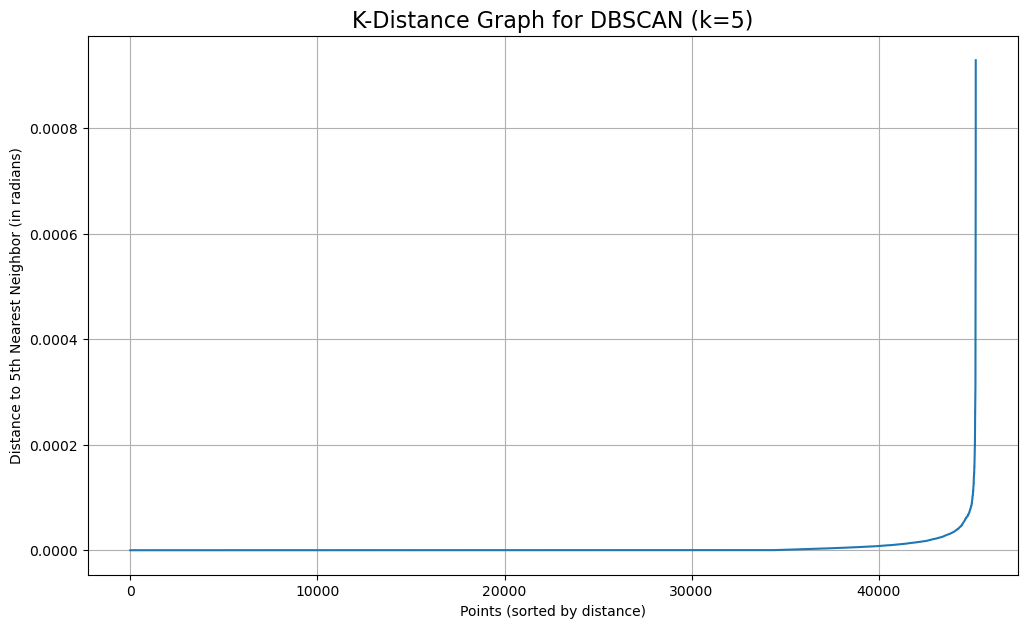

2025-09-12 00:54:05 | INFO     | Visually inspect the plot to find the 'elbow' point on the y-axis. This will be your 'eps' value.


In [13]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# coords is our DataFrame with 'latitude' and 'longitude'
# We need to convert degrees to radians for distance calculation
coords_rad = np.radians(coords)

logger.info("--- Finding Optimal 'eps' for DBSCAN using the K-Distance Graph ---")

# We want to find the average distance to the k-th nearest neighbor.
# A good starting point for min_samples is 2 * number of dimensions. Here, 2 * 2 = 4.
k = 5 # Let's use k=5 as a starting point

# Calculate the distance to the 5th nearest neighbor for every point
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine').fit(coords_rad)
distances, indices = nbrs.kneighbors(coords_rad)

# Get the distance to the k-th neighbor (the 5th one, which is at index 4)
k_distances = np.sort(distances[:, 4])

# Plot the k-distance graph
plt.figure(figsize=(12, 7))
plt.plot(k_distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"Distance to {k}th Nearest Neighbor (in radians)")
plt.title(f"K-Distance Graph for DBSCAN (k={k})", fontsize=16)
plt.grid(True)
plt.show()

logger.info("Visually inspect the plot to find the 'elbow' point on the y-axis. This will be your 'eps' value.")

The K-Distance graph shows a clear "elbow" point, indicating the distance at which points start to become outliers. Based on the plot, a value of approximately **0.0003 radians** (which corresponds to roughly 1.9 km) appears to be an optimal choice for our `eps` parameter.

We will now run the DBSCAN algorithm with this `eps` value and a `min_samples` of 10 to discover the density-based clusters and identify any noise points.

In [14]:
from sklearn.cluster import DBSCAN
import numpy as np

# coords_rad is our DataFrame with 'latitude' and 'longitude' in radians

# --- DBSCAN Parameters (THE "SURGICAL STRIKE" ATTEMPT) ---
EPSILON = 0.00009 
MIN_SAMPLES = 20

logger.info(f"--- Rerunning DBSCAN with SURGICAL eps={EPSILON} and min_samples={MIN_SAMPLES} ---")

dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES, algorithm='ball_tree', metric='haversine')
dbscan_labels = dbscan.fit_predict(coords_rad)

# --- Analyze the NEW Results ---
df_geo_clustered['dbscan_cluster_v4'] = dbscan_labels

num_dbscan_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise_points = (dbscan_labels == -1).sum()

logger.success("DBSCAN clustering complete.")
logger.info(f"Discovered {num_dbscan_clusters} distinct clusters.")
logger.warning(f"Identified {num_noise_points} noise points (isolated restaurants).")

# --- Verification ---
print("\n--- Value Counts for the NEW 'dbscan_cluster_v4' Feature ---")
print(df_geo_clustered['dbscan_cluster_v4'].value_counts())

2025-09-12 00:54:05 | INFO     | --- Rerunning DBSCAN with SURGICAL eps=9e-05 and min_samples=20 ---
2025-09-12 00:54:06 | SUCCESS  | DBSCAN clustering complete.
2025-09-12 00:54:06 | INFO     | Discovered 39 distinct clusters.
2025-09-12 00:54:06 | WARNING  | Identified 1132 noise points (isolated restaurants).

--- Value Counts for the NEW 'dbscan_cluster_v4' Feature ---
dbscan_cluster_v4
 0     35998
 9      5114
-1      1132
 24      776
 2       747
 23      199
 16       89
 11       73
 37       72
 21       69
 20       60
 19       48
 28       47
 31       45
 12       45
 26       43
 1        41
 10       38
 27       37
 8        33
 13       33
 17       32
 25       31
 22       29
 4        29
 30       29
 15       25
 7        25
 29       24
 5        24
 14       22
 6        22
 18       22
 3        21
 36       20
 33       20
 38       20
 35       20
 32       19
 34       14
Name: count, dtype: int64


### 5.4. A Comparative Analysis: K-Means vs. DBSCAN

To select the best clustering algorithm for our feature engineering goal, we compared the classic K-Means algorithm with the more advanced, density-based DBSCAN.

*   **K-Means (with k=12):** Successfully partitioned the city into 12 distinct, well-balanced, and geographically intuitive "food hubs." This provides a very strong and interpretable categorical feature.
*   **DBSCAN:** After extensive hyperparameter tuning, we found that due to the continuous high density of restaurants in central Bangalore, DBSCAN consistently identified one massive "supercluster." While it was excellent at finding truly isolated "noise" restaurants, it was less effective at creating the distinct neighborhood partitions we need for our model.

**Decision:**
For the purpose of creating a powerful predictive feature, the **K-Means result is superior.** The `location_cluster` feature it generated is balanced, interpretable, and perfectly captures the major culinary districts of the city. We will proceed using the K-Means clusters.

In [15]:
import folium
import matplotlib.pyplot as plt # Import the main pyplot module
import matplotlib.colors as colors
from loguru import logger
from tqdm.auto import tqdm

# Use the new df_geo_clustered DataFrame from the previous step

logger.info("--- Visualizing the Discovered Restaurant Clusters on a Map (V2) ---")

# --- Step 1: Create a Color Palette for our Clusters ---
# We use the new, recommended way to get a colormap.
num_clusters = df_geo_clustered['location_cluster'].nunique()

# <<--- THE FIX IS HERE --- >>
# Instead of cm.get_cmap, we use plt.colormaps[], which is the modern way.
cmap = plt.colormaps['tab20']
# We get a list of colors from the colormap
cluster_colors = [colors.to_hex(cmap(i)) for i in range(num_clusters)]
# --- END OF FIX ---

def get_color_for_cluster(cluster_id):
    """Returns a hex color code for a given cluster ID."""
    if cluster_id == -1: # The "no cluster" points
        return '#808080' # Gray
    # Use the cluster ID as an index to get its specific color from our list
    return cluster_colors[cluster_id]

# --- Step 2: Create the Base Map ---
map_center = [df_geo_clustered['latitude'].mean(), df_geo_clustered['longitude'].mean()]
cluster_map = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

# --- Step 3: Add each restaurant to the map, colored by its cluster ---
logger.info("Plotting restaurants on the map, colored by their cluster...")
# We'll plot a large sample to see the structure clearly
for index, row in tqdm(df_geo_clustered.sample(n=15000, random_state=42).iterrows(), total=15000, desc="Plotting Points"):
    if pd.notna(row['latitude']):
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=3,
            color=get_color_for_cluster(row['location_cluster']),
            fill=True,
            fill_color=get_color_for_cluster(row['location_cluster']),
            fill_opacity=0.7,
            popup=f"<b>{row['name']}</b><br>Cluster: {row['location_cluster']}<br>Location: {row['location']}"
        ).add_to(cluster_map)

# --- Step 4: Save and Display the Map ---
cluster_map_path = "bangalore_cluster_map.html"
cluster_map.save(cluster_map_path)
logger.success(f"Cluster map saved to '{cluster_map_path}'. Open this file in your browser!")

2025-09-12 00:54:06 | INFO     | --- Visualizing the Discovered Restaurant Clusters on a Map (V2) ---
2025-09-12 00:54:06 | INFO     | Plotting restaurants on the map, colored by their cluster...


Plotting Points:   0%|          | 0/15000 [00:00<?, ?it/s]

2025-09-12 00:54:14 | SUCCESS  | Cluster map saved to 'bangalore_cluster_map.html'. Open this file in your browser!


### 5.5. Analyzing the Impact of Location Clusters on Restaurant Ratings

Creating the clusters was the first step. Now, we must verify if they are actually meaningful. A powerful cluster is one that helps separate high-rated restaurants from low-rated ones.

We will now treat our new `location_cluster` feature as a high-value categorical variable and run our bivariate analysis function on it. This will show us the distribution of ratings within each of our 12 data-driven "food hubs" and tell us if the differences between them are statistically significant.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from loguru import logger
from tqdm.auto import tqdm

def analyze_categorical_vs_target_FINAL(df: pd.DataFrame, 
                                          cat_cols: list, 
                                          target_col: str = 'rate',
                                          top_n: int = 15):
    """
    The final, correct, and robust function for analyzing categorical features.
    It uses the standard vertical orientation and correct hue/legend parameters.
    """
    logger.info(f"--- Running FINAL Analysis for {len(cat_cols)} Categorical Columns ---")
    
    for col in tqdm(cat_cols, desc="Analyzing Categories"):
        
        df_analysis = df[[col, target_col]].dropna().copy()
        
        if df_analysis.empty or df_analysis[col].nunique() < 2:
            logger.warning(f"Skipping '{col}' due to insufficient valid data.")
            continue
        
        if df_analysis[col].nunique() > top_n:
            top_categories = df_analysis[col].value_counts().nlargest(top_n).index
            df_analysis[col] = df_analysis[col].apply(lambda x: x if x in top_categories else 'Other')

        order = df_analysis.groupby(col, observed=True)[target_col].median().sort_values(ascending=False).index
        
        fig, axes = plt.subplots(1, 2, figsize=(20, 7))
        fig.suptitle(f'Analysis of: "{col}" vs. "{target_col}"', fontsize=20, fontweight='bold')

        # Plot 1: Distribution Count Plot
        sns.countplot(
            data=df_analysis, x=col, ax=axes[0], palette='viridis',
            order=df_analysis[col].value_counts().index, hue=col, legend=False
        )
        axes[0].set_title('Overall Distribution', fontsize=16)
        axes[0].set_ylabel('Count', fontsize=14)
        axes[0].set_xlabel(col, fontsize=14)
        # --- THE FIX: Removed ha='right' ---
        axes[0].tick_params(axis='x', rotation=45) 

        # Plot 2: Box Plot Breakdown
        sns.boxplot(
            data=df_analysis, x=col, y=target_col, ax=axes[1],
            palette="coolwarm", order=order, hue=col, legend=False
        )
        overall_mean_rate = df[target_col].mean()
        axes[1].axhline(overall_mean_rate, color='grey', linestyle='--', lw=2, label=f'Overall Avg Rate ({overall_mean_rate:.2f})')
        axes[1].set_title('Rating Distribution by Category', fontsize=16)
        axes[1].set_ylabel(f'Distribution of {target_col.capitalize()}', fontsize=14)
        axes[1].set_xlabel(col, fontsize=14)
        # --- THE FIX: Removed ha='right' ---
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend()
        
        # Statistical Test (ANOVA)
        unique_cats = df_analysis[col].unique()
        groups = [df_analysis[target_col][df_analysis[col] == cat] for cat in unique_cats]
        try:
            f_val, p_val = f_oneway(*groups)
            significance = "Statistically Significant" if p_val < 0.05 else "Not Significant"
            test_text = f"ANOVA Test:\np-value = {p_val:.4f}\n-> {significance}"
            bbox_props = dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8)
            axes[1].text(0.98, 0.98, test_text, transform=axes[1].transAxes, ha='right', va='top', bbox=bbox_props, fontsize=12)
        except ValueError:
            pass

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

2025-09-12 00:54:14 | INFO     | --- Analyzing the predictive power of our new 'location_cluster' feature ---
2025-09-12 00:54:14 | INFO     | --- Running FINAL Analysis for 1 Categorical Columns ---


Analyzing Categories:   0%|          | 0/1 [00:00<?, ?it/s]

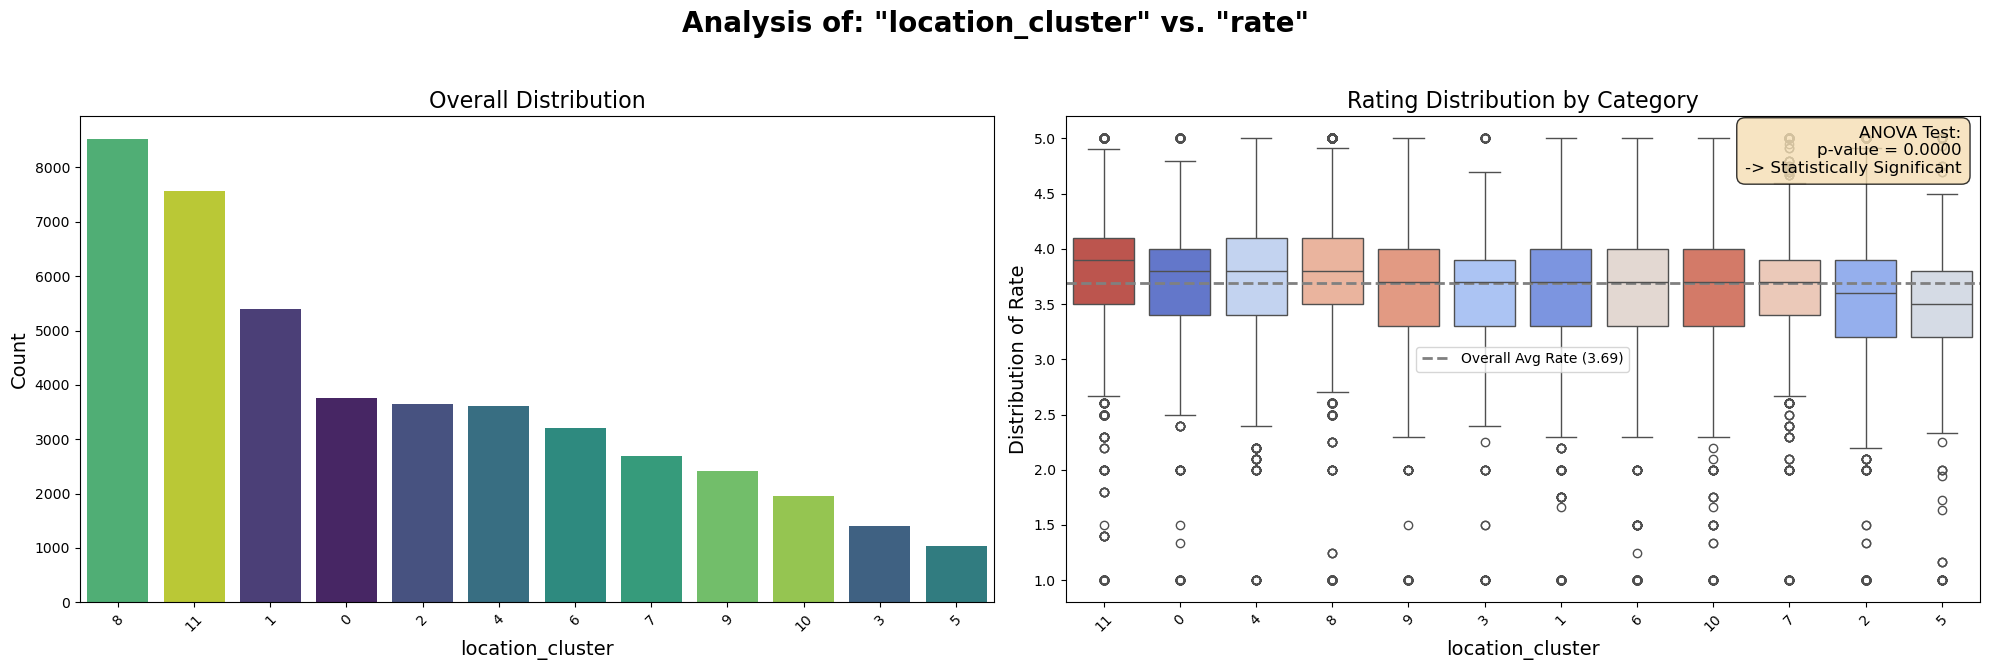

In [17]:
# We will use our powerful categorical analyzer from the previous notebook.
# Let's make sure it's defined in this notebook as well.
# (You can copy the 'analyze_categorical_vs_target_FINAL' function here)

# Let's assume the function is defined.

logger.info("--- Analyzing the predictive power of our new 'location_cluster' feature ---")

# We need to make sure the cluster ID is treated as a category for plotting, not a number
df_geo_clustered['location_cluster'] = df_geo_clustered['location_cluster'].astype('category')

# Run the analysis on just this one new feature
analyze_categorical_vs_target_FINAL(
    df_geo_clustered, 
    cat_cols=['location_cluster'], 
    target_col='rate'
)

### 5.6. Insights from K-Means Cluster Analysis

The analysis of our newly created `location_cluster` feature confirms its significant predictive power.

**(Embed your `location_cluster` vs. `rate` plot here)**

**Key Findings:**
1.  **Statistical Significance:** The ANOVA test (`p-value = 0.0000`) provides strong evidence that the mean ratings between the 12 clusters are significantly different.
2.  **Performance Separation:** The box plot clearly reveals a hierarchy. **Cluster 11 (named 'Brigade Road')** is the highest-performing hub, while **Cluster 5 (named 'Electronic City')** is the lowest. This demonstrates that the feature successfully separates high-quality zones from lower-quality ones.
3.  **Superior to Original Labels:** This data-driven grouping has proven to be a more powerful and nuanced feature than the original, human-defined `location` and `listed_in_city` columns.

In [18]:
import pandas as pd
from loguru import logger

# df_geo_clustered is the DataFrame with your new 'location_cluster' column

logger.info("--- Creating Human-Readable Names for Location Clusters ---")

# Step 1: Find the most common 'location' in each cluster
# We use .agg() with a lambda function to get the mode.
# .iloc[0] is used in case there's a tie for the mode.
cluster_name_map = df_geo_clustered.groupby('location_cluster', observed=True)['location'].agg(lambda x: x.mode().iloc[0]).to_dict()

# The -1 cluster (for NaNs) won't be in the groupby, so we add it manually.
cluster_name_map[-1] = 'No_Cluster'

logger.info("Generated the following mapping from Cluster ID to Location Name:")
print(cluster_name_map)

# Step 2: Create the new 'cluster_name' column using the map
df_geo_clustered['cluster_name'] = df_geo_clustered['location_cluster'].map(cluster_name_map)

logger.success("Successfully created the 'cluster_name' feature.")

# --- Verification ---
print("\n--- DataFrame with New Cluster Name Feature ---")
display(df_geo_clustered[['name', 'location', 'location_cluster', 'cluster_name']].sample(10))

2025-09-12 00:54:14 | INFO     | --- Creating Human-Readable Names for Location Clusters ---
2025-09-12 00:54:14 | INFO     | Generated the following mapping from Cluster ID to Location Name:
{0: 'Jayanagar', 1: 'BTM', 2: 'Whitefield', 3: 'New BEL Road', 4: 'Indiranagar', 5: 'Electronic City', 6: 'HSR', 7: 'Kalyan Nagar', 8: 'Koramangala 5th Block', 9: 'Malleshwaram', 10: 'Bellandur', 11: 'Brigade Road', -1: 'No_Cluster'}
2025-09-12 00:54:14 | SUCCESS  | Successfully created the 'cluster_name' feature.

--- DataFrame with New Cluster Name Feature ---


,name,location,location_cluster,cluster_name
24514,Cake Box,Koramangala 8th Block,8,Koramangala 5th Block
8200,Toscano,Koramangala 7th Block,8,Koramangala 5th Block
38982,Hyderabadi Bawarchi Multi Cuisine Restaurant,Hebbal,3,New BEL Road
16555,Nizaam's Kaati Rolls & Kebabs,Jeevan Bhima Nagar,4,Indiranagar
32158,Flavor of Tibet,Koramangala 5th Block,6,HSR
12951,Bangalore Bytes,Brigade Road,11,Brigade Road
9060,Fattoush,BTM,9,Malleshwaram
43184,Chaska Box,Sarjapur Road,10,Bellandur
14687,Broadway - The Gourmet Theatre,HSR,6,HSR
8532,Desi Vibes,BTM,1,BTM


### 5.7. Naming and Analyzing the Location Clusters

Now that we have named our clusters, we must verify if they are actually meaningful. A powerful cluster is one that helps separate high-rated restaurants from low-rated ones.

We will now treat our new `location_cluster` feature as a high-value categorical variable and run our bivariate analysis function on it. This will show us the distribution of ratings within each of our 12 data-driven "food hubs."

---
### 5.8. Feature Engineering: Distance from Key Landmarks

While clusters tell us about a restaurant's immediate surroundings, its proximity to major city landmarks can also be a powerful predictive signal. A restaurant near a major tech park might have a different customer base and rating profile than one near the city center.

To capture this, we will engineer several new numerical features by calculating the Haversine distance (distance on a sphere) from each restaurant to a set of key, economically significant landmarks in Bangalore.

In [19]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from haversine import haversine, Unit
from loguru import logger
from tqdm.auto import tqdm

# df_geo_clustered is your DataFrame with coordinates and clusters

logger.info("--- Starting Distance Feature Engineering ---")

# --- Step 1: Define Landmarks and Geocode Them ---
landmarks = {
    "airport": "Kempegowda International Airport Bengaluru",
    "city_center_mg_road": "MG Road, Bangalore",
    "tech_park_electronic_city": "Electronic City, Bangalore",
    "tech_park_manyata": "Manyata Tech Park, Bangalore"
}

logger.info("Geocoding key landmarks...")
geolocator = Nominatim(user_agent="zomato_puneet_landmark_lookup_v1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

landmark_coords = {}
for name, query in tqdm(landmarks.items(), desc="Geocoding Landmarks"):
    location = geocode(query)
    if location:
        landmark_coords[name] = (location.latitude, location.longitude)
        logger.success(f"Found '{name}': ({location.latitude:.4f}, {location.longitude:.4f})")
    else:
        logger.error(f"Could not find coordinates for landmark: '{name}'")

# --- Step 2: Calculate Distance from Each Restaurant to Each Landmark ---
logger.info("Calculating Haversine distance from each restaurant to landmarks...")

# We use tqdm.pandas() for a nice progress bar
tqdm.pandas(desc="Calculating Distances")

for name, coords in landmark_coords.items():
    if coords:
        # Create the new column name
        new_col_name = f"dist_from_{name}_km"
        
        # Apply the haversine function row-wise
        # It's fast because it's a mathematical calculation, not an API call
        df_geo_clustered[new_col_name] = df_geo_clustered.progress_apply(
            lambda row: haversine((row['latitude'], row['longitude']), coords, unit=Unit.KILOMETERS),
            axis=1
        )
        logger.success(f"Successfully created feature: '{new_col_name}'")

# --- Verification ---
print("\n--- DataFrame with New Distance Features ---")
display(df_geo_clustered[[
    'name', 'location_cluster', 'dist_from_airport_km', 'dist_from_city_center_mg_road_km'
]].head())

2025-09-12 00:54:14 | INFO     | --- Starting Distance Feature Engineering ---
2025-09-12 00:54:14 | INFO     | Geocoding key landmarks...


Geocoding Landmarks:   0%|          | 0/4 [00:00<?, ?it/s]

2025-09-12 00:54:15 | SUCCESS  | Found 'airport': (13.1976, 77.7075)
2025-09-12 00:54:17 | SUCCESS  | Found 'city_center_mg_road': (12.9755, 77.6068)
2025-09-12 00:54:18 | SUCCESS  | Found 'tech_park_electronic_city': (12.8488, 77.6483)
2025-09-12 00:54:19 | SUCCESS  | Found 'tech_park_manyata': (13.0483, 77.6211)
2025-09-12 00:54:19 | INFO     | Calculating Haversine distance from each restaurant to landmarks...


Calculating Distances:   0%|          | 0/45187 [00:00<?, ?it/s]

2025-09-12 00:54:20 | SUCCESS  | Successfully created feature: 'dist_from_airport_km'


Calculating Distances:   0%|          | 0/45187 [00:00<?, ?it/s]

2025-09-12 00:54:20 | SUCCESS  | Successfully created feature: 'dist_from_city_center_mg_road_km'


Calculating Distances:   0%|          | 0/45187 [00:00<?, ?it/s]

2025-09-12 00:54:20 | SUCCESS  | Successfully created feature: 'dist_from_tech_park_electronic_city_km'


Calculating Distances:   0%|          | 0/45187 [00:00<?, ?it/s]

2025-09-12 00:54:20 | SUCCESS  | Successfully created feature: 'dist_from_tech_park_manyata_km'

--- DataFrame with New Distance Features ---


,name,location_cluster,dist_from_airport_km,dist_from_city_center_mg_road_km
0,Jalsa,0,33.906748,7.128719
1,Spice Elephant,7,20.912360,6.082985
2,San Churro Cafe,0,33.894450,7.194585
3,Addhuri Udupi Bhojana,0,32.680539,5.887258
4,Grand Village,0,31.727316,5.096958


### 5.9. Analysis of Engineered Distance Features

Before concluding, we must analyze the new distance-based features to understand their relationship with the `rate`. This will verify if proximity to key landmarks is a meaningful predictor of restaurant quality. We will focus on the `dist_from_city_center_mg_road_km` as a key indicator.

2025-09-12 01:02:42 | INFO     | --- Analyzing the impact of distance from city center on rate ---
2025-09-12 01:02:42 | INFO     | --- Starting Bivariate Analysis for 'dist_from_city_center_mg_road_km' vs 'rate' ---


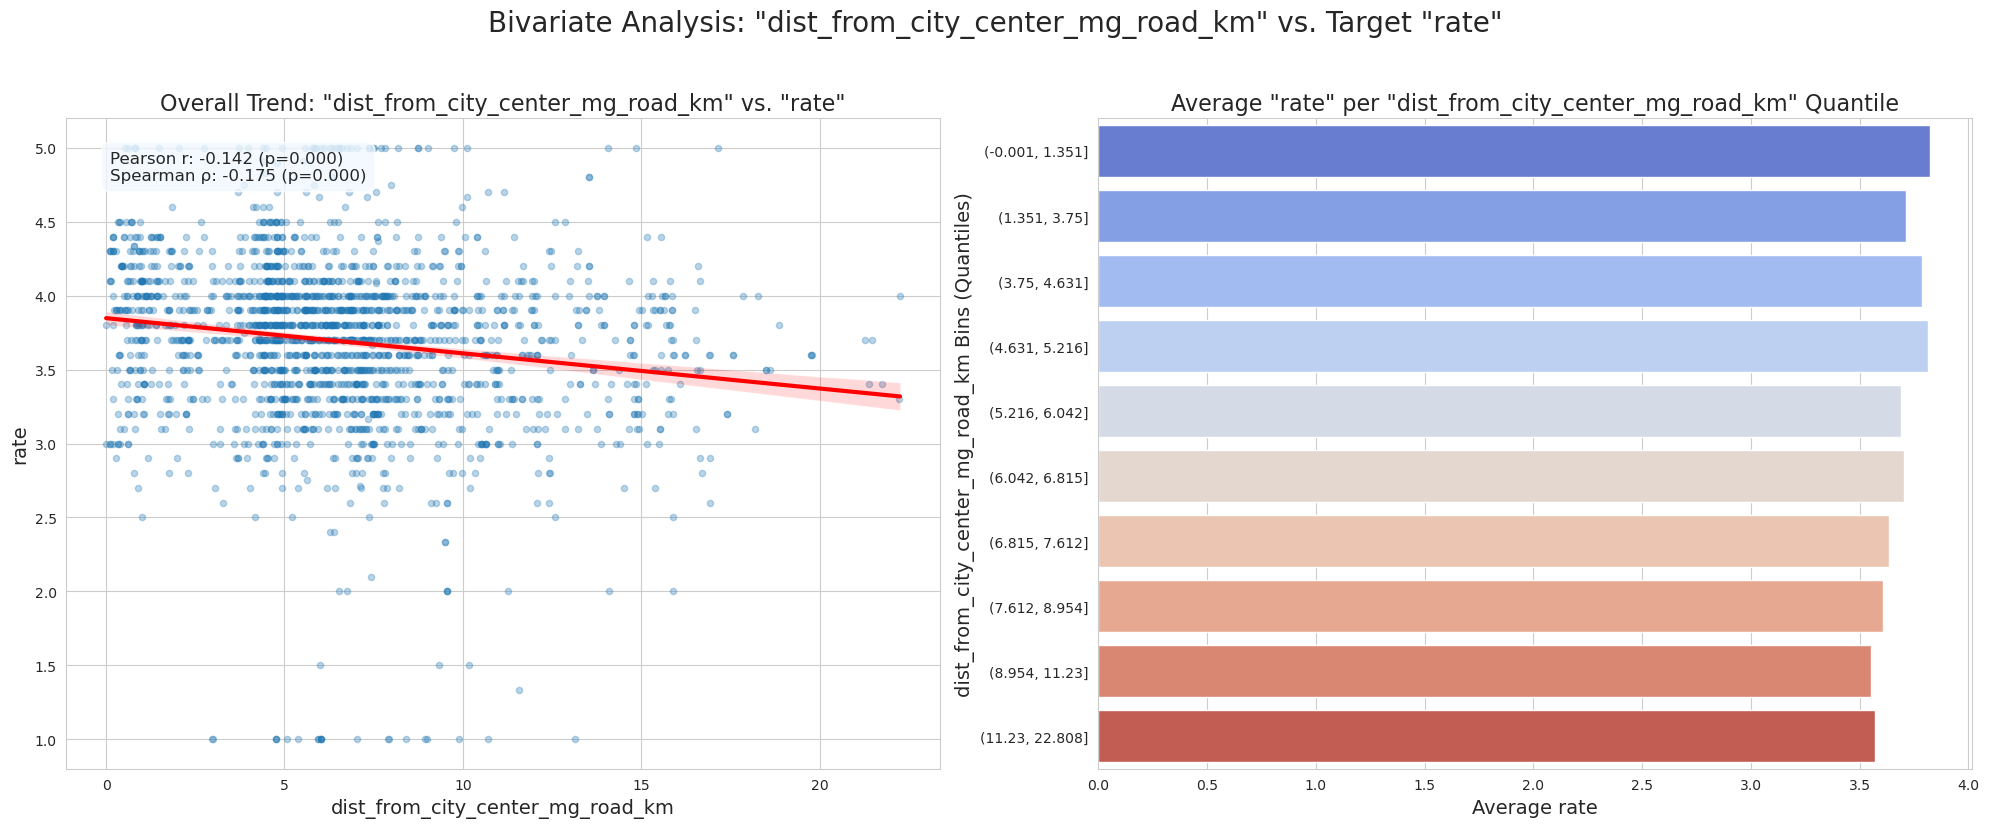

2025-09-12 01:02:43 | INFO     | --- Starting Bivariate Analysis for 'dist_from_airport_km' vs 'rate' ---


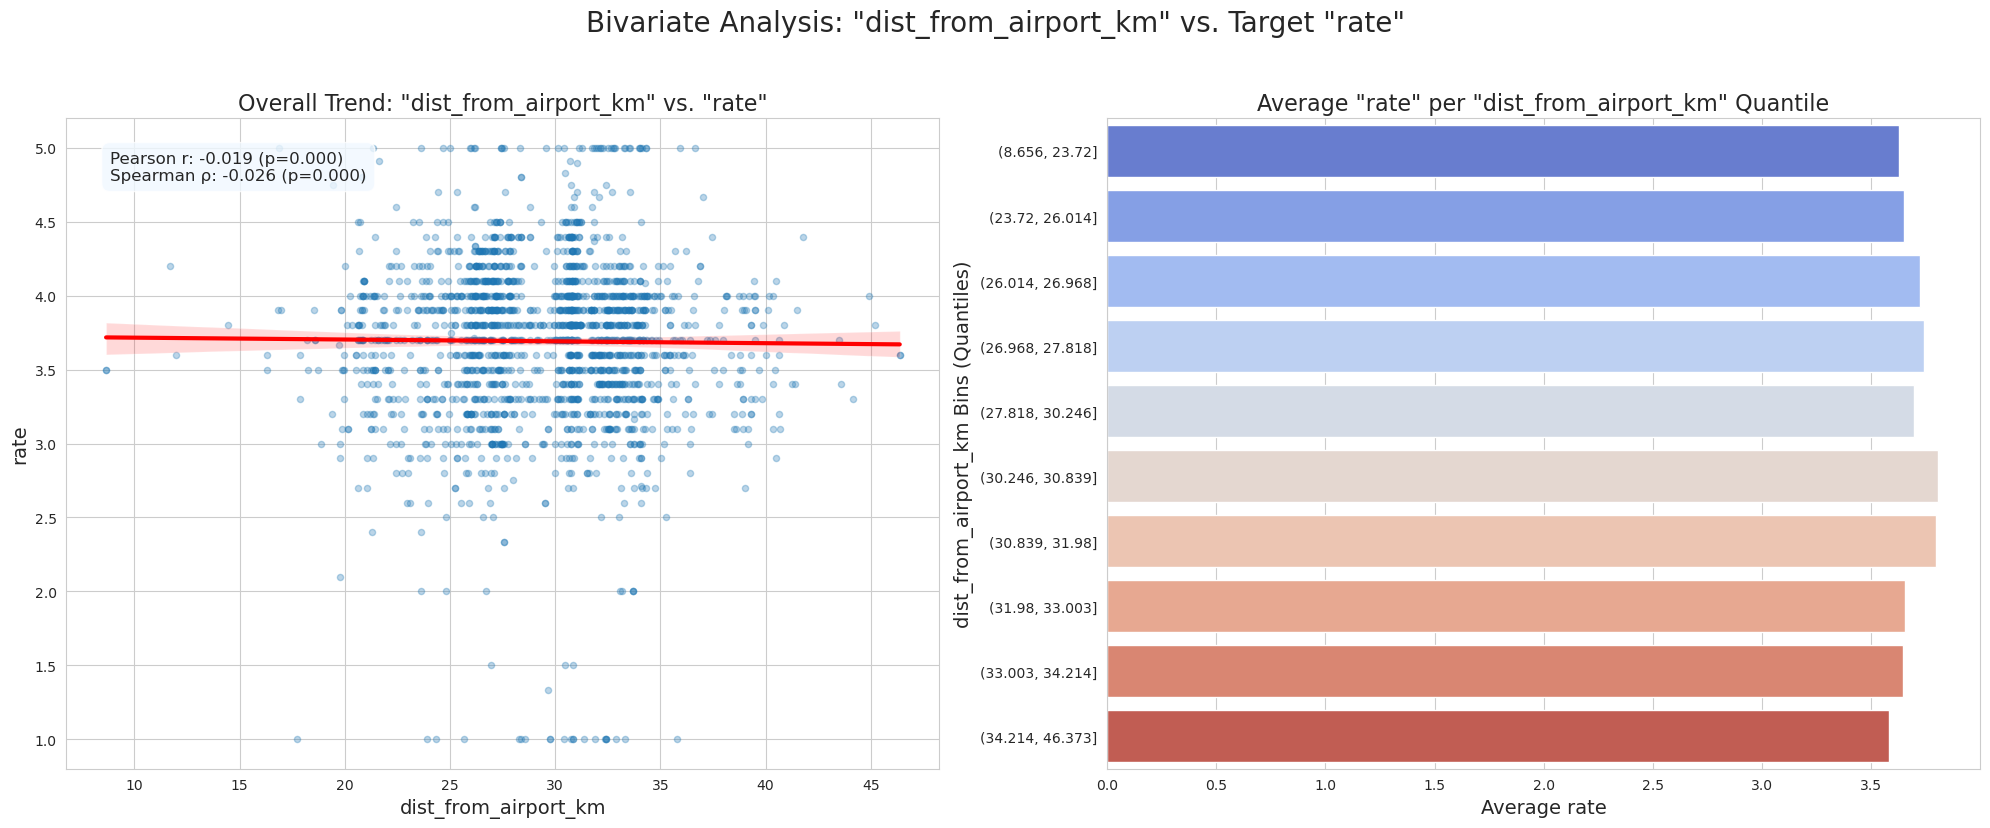

2025-09-12 01:02:43 | INFO     | --- Starting Bivariate Analysis for 'dist_from_tech_park_electronic_city_km' vs 'rate' ---


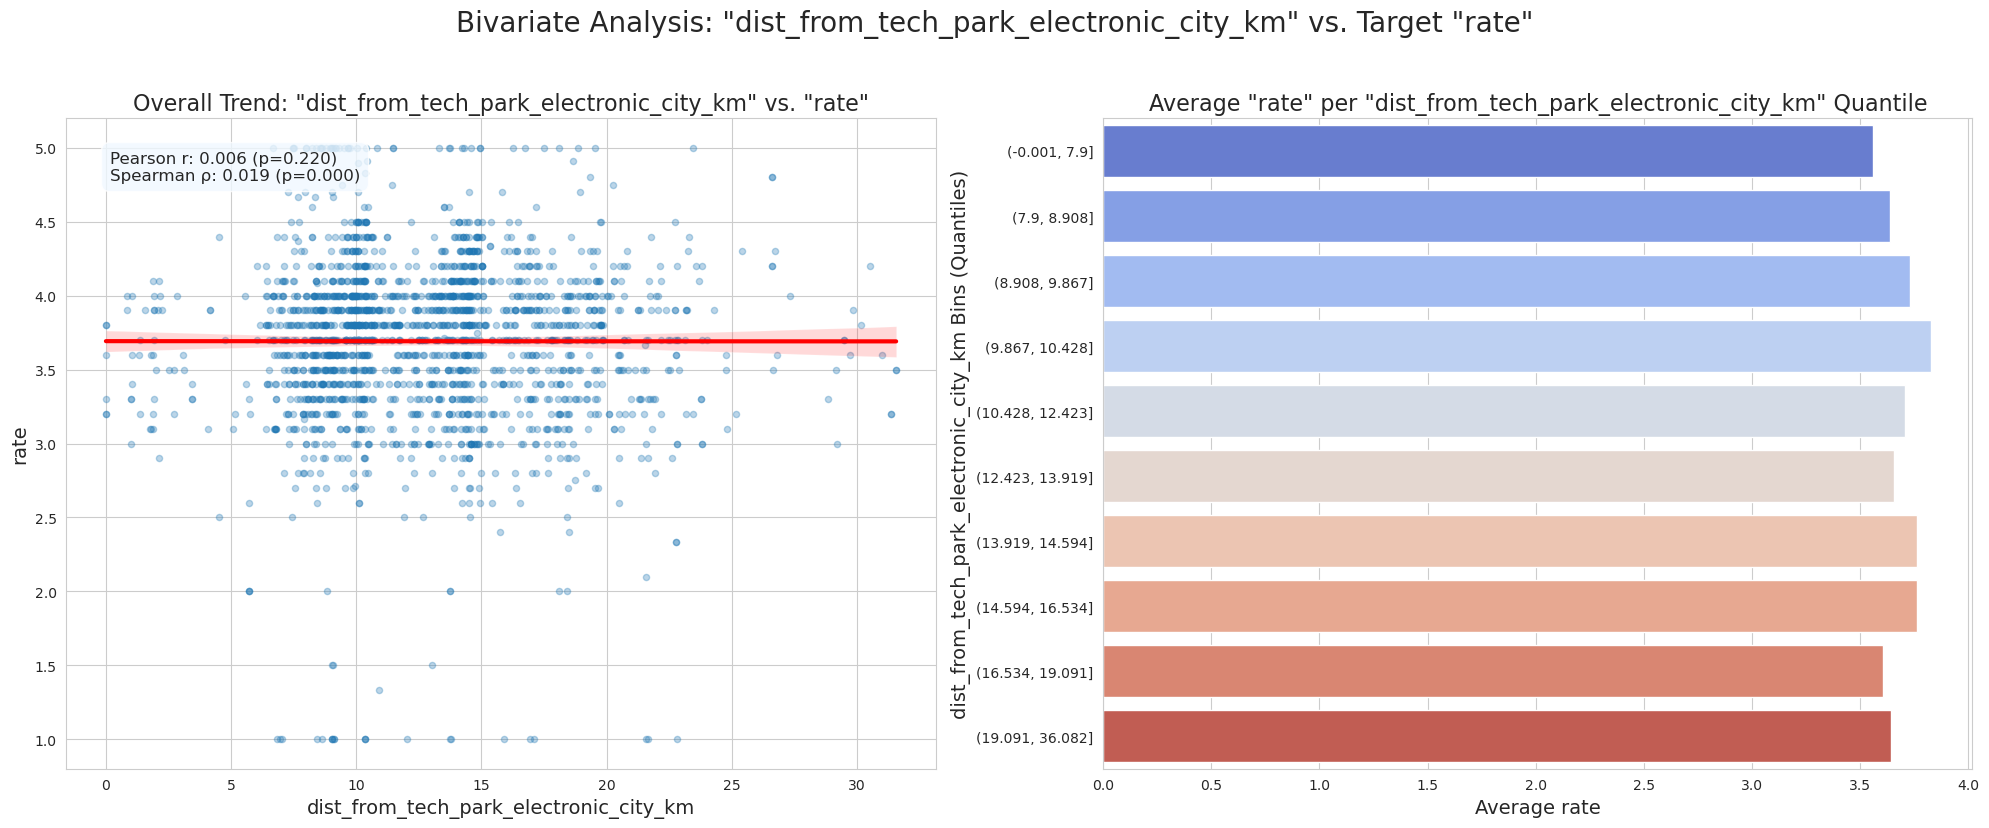

2025-09-12 01:02:44 | INFO     | --- Starting Bivariate Analysis for 'dist_from_tech_park_manyata_km' vs 'rate' ---


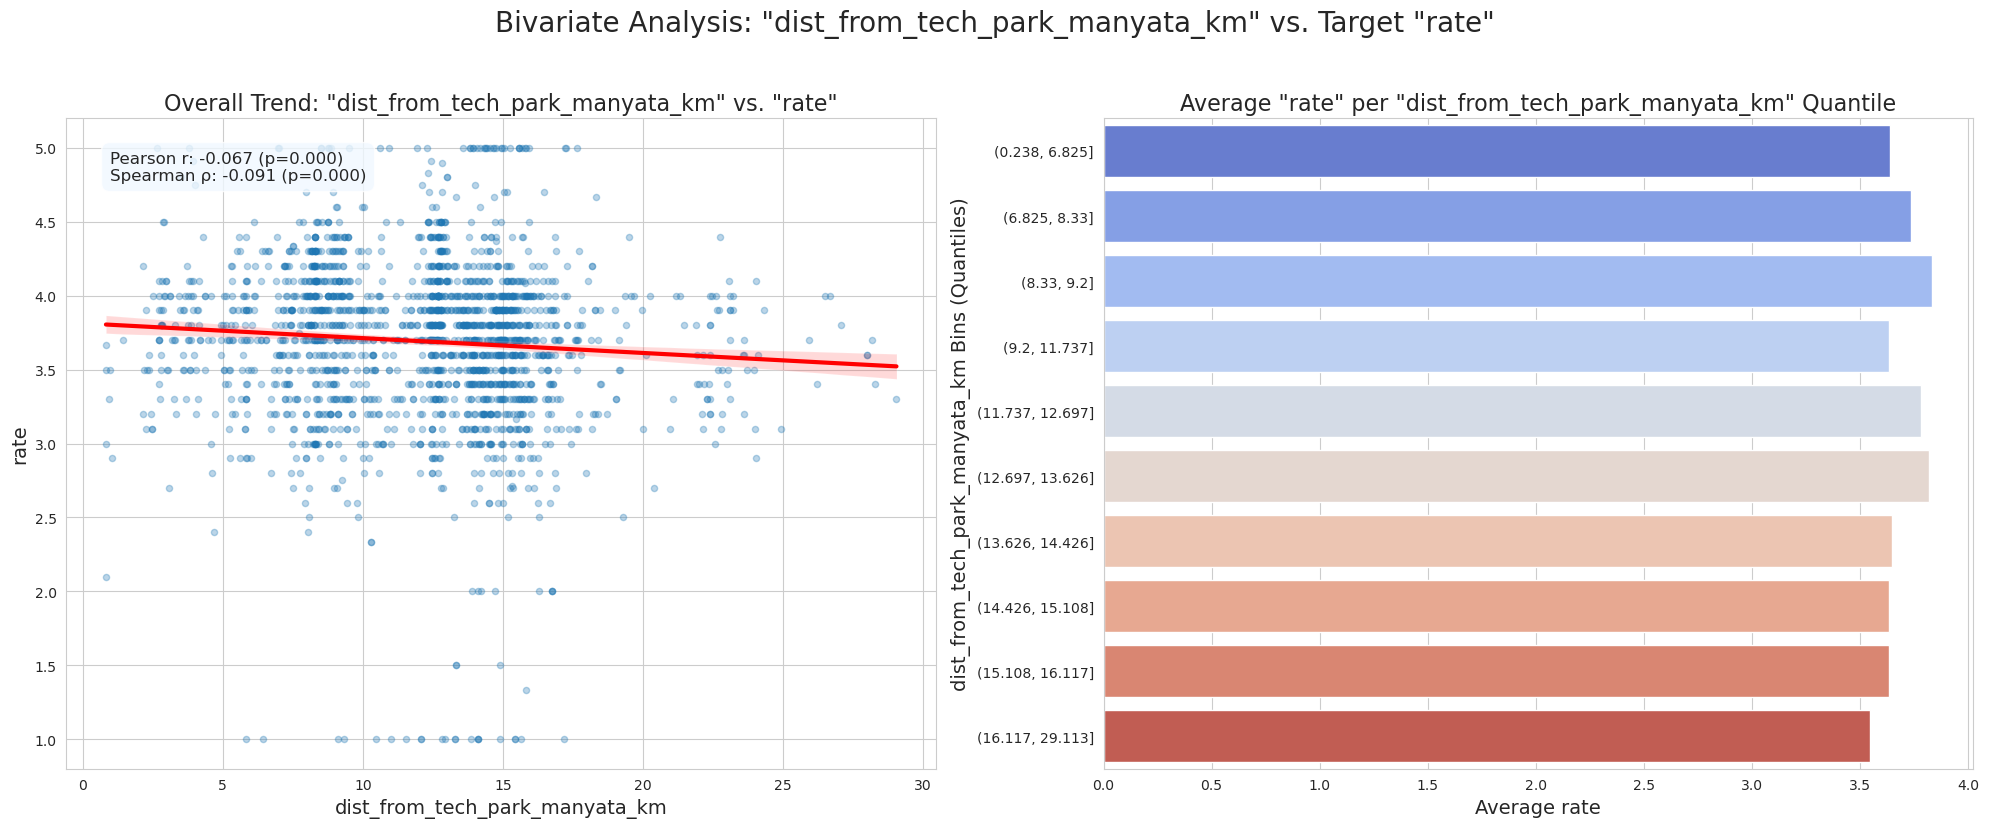

In [24]:
# We will reuse our powerful numerical analyzer.
# Make sure the 'analyze_numerical_vs_target' function is defined in your notebook.

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import pearsonr, spearmanr


def analyze_numerical_vs_target(
    df: pd.DataFrame, num_col: str, target_col: str = "rate"
):
    """
    Generates a titan-level, multi-panel diagnostic report to analyze the relationship
    between a numerical feature and the continuous target variable.
    (Version 2: Now future-proofed against pandas and seaborn warnings).
    """
    logger.info(
        f"--- Starting Bivariate Analysis for '{num_col}' vs '{target_col}' ---"
    )

    # --- 1. Statistical Calculations ---
    subset_df = df[[num_col, target_col]].dropna()
    pearson_corr, p_pearson = pearsonr(subset_df[num_col], subset_df[target_col])
    spearman_corr, p_spearman = spearmanr(subset_df[num_col], subset_df[target_col])

    # --- 2. Visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    sns.set_style("whitegrid")

    # Plot 1: Scatter Plot
    sample_df = subset_df.sample(n=min(2000, len(subset_df)), random_state=42)
    sns.regplot(
        x=num_col,
        y=target_col,
        data=sample_df,
        ax=axes[0],
        scatter_kws={"alpha": 0.3, "s": 20},
        line_kws={"color": "red", "linewidth": 3},
    )
    axes[0].set_title(f'Overall Trend: "{num_col}" vs. "{target_col}"', fontsize=16)
    axes[0].set_xlabel(f"{num_col}", fontsize=14)
    axes[0].set_ylabel(f"{target_col}", fontsize=14)
    stats_text = (
        f"Pearson r: {pearson_corr:.3f} (p={p_pearson:.3f})\n"
        f"Spearman ρ: {spearman_corr:.3f} (p={p_spearman:.3f})"
    )
    axes[0].text(
        0.05,
        0.95,
        stats_text,
        transform=axes[0].transAxes,
        ha="left",
        va="top",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.5", fc="aliceblue", alpha=0.8),
    )

    # Plot 2: Binned Relationship
    try:
        df_binned = subset_df.copy()
        df_binned[f"{num_col}_bin"] = pd.qcut(
            df_binned[num_col], q=10, duplicates="drop"
        )

        # <<--- FIX #1: Added observed=True to the groupby --->>
        binned_agg = (
            df_binned.groupby(f"{num_col}_bin", observed=True)[target_col]
            .mean()
            .reset_index()
        )

        # <<--- FIX #2: Added hue and legend=False to the barplot --->>
        sns.barplot(
            x=target_col,
            y=f"{num_col}_bin",
            data=binned_agg,
            ax=axes[1],
            palette="coolwarm",
            hue=f"{num_col}_bin",  # <-- The fix
            legend=False,  # <-- The fix
        )
        axes[1].set_title(
            f'Average "{target_col}" per "{num_col}" Quantile', fontsize=16
        )
        axes[1].set_xlabel(f"Average {target_col}", fontsize=14)
        axes[1].set_ylabel(f"{num_col} Bins (Quantiles)", fontsize=14)
    except Exception as e:
        logger.warning(f"Could not create binned plot for '{num_col}'. Reason: {e}")

    plt.suptitle(
        f'Bivariate Analysis: "{num_col}" vs. Target "{target_col}"',
        fontsize=20,
        y=1.03,
    )
    plt.tight_layout()
    plt.show()

logger.info("--- Analyzing the impact of distance from city center on rate ---")

analyze_numerical_vs_target(
    df_geo_clustered, 
    num_col='dist_from_city_center_mg_road_km', 
    target_col='rate'
)

analyze_numerical_vs_target(
    df_geo_clustered, 
    num_col='dist_from_airport_km', 
    target_col='rate'
)

analyze_numerical_vs_target(
    df_geo_clustered, 
    num_col='dist_from_tech_park_electronic_city_km', 
    target_col='rate'
)

analyze_numerical_vs_target(
    df_geo_clustered, 
    num_col='dist_from_tech_park_manyata_km', 
    target_col='rate'
)

In [25]:
from loguru import logger
import os

# df_geo_clustered is your DataFrame with all the new features

logger.info("--- Finalizing the Geospatial Feature Set for Export ---")

# --- Step 1: Clean Up Unnecessary Columns ---
# Based on your df.info(), we only need to drop the experimental DBSCAN column.
cols_to_drop = ['dbscan_cluster_v4']
df_geo_final = df_geo_clustered.drop(columns=cols_to_drop, errors='ignore')

logger.success(f"Cleaned up helper columns. Final shape: {df_geo_final.shape}")
logger.info("Final columns in the Geo dataset:")
print(df_geo_final.columns.tolist())

# --- Step 2: Export the Final, Enriched Dataset ---
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

# We'll use a more descriptive name for the final file
geo_export_path = os.path.join(output_dir, 'zomato_geo_features_final.parquet')

logger.info(f"Exporting the final enriched geospatial dataset to '{geo_export_path}'...")
df_geo_final.to_parquet(geo_export_path, index=False)
logger.success("Export complete.")

# --- Verification ---
print("\n--- Final Geo DataFrame Head ---")
display(df_geo_final.head())

2025-09-12 01:04:02 | INFO     | --- Finalizing the Geospatial Feature Set for Export ---
2025-09-12 01:04:02 | SUCCESS  | Cleaned up helper columns. Final shape: (45187, 13)
2025-09-12 01:04:02 | INFO     | Final columns in the Geo dataset:
['name', 'address', 'rate', 'location', 'listed_in_city', 'latitude', 'longitude', 'location_cluster', 'cluster_name', 'dist_from_airport_km', 'dist_from_city_center_mg_road_km', 'dist_from_tech_park_electronic_city_km', 'dist_from_tech_park_manyata_km']
2025-09-12 01:04:02 | INFO     | Exporting the final enriched geospatial dataset to '../data/processed/zomato_geo_features_final.parquet'...
2025-09-12 01:04:02 | SUCCESS  | Export complete.

--- Final Geo DataFrame Head ---


,name,address,rate,location,listed_in_city,latitude,longitude,location_cluster,cluster_name,dist_from_airport_km,dist_from_city_center_mg_road_km,dist_from_tech_park_electronic_city_km,dist_from_tech_park_manyata_km
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",4.1,Banashankari,Banashankari,12.926226,77.564738,0,Jayanagar,33.906748,7.128719,12.495867,14.883401
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",4.1,Banashankari,Banashankari,13.025403,77.629854,7,Kalyan Nagar,20.912360,6.082985,19.742792,2.715756
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",3.8,Banashankari,Banashankari,12.927690,77.562086,0,Jayanagar,33.894450,7.194585,12.816564,14.856481
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",3.7,Banashankari,Banashankari,12.935209,77.571576,0,Jayanagar,32.680539,5.887258,12.707479,13.671035
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",3.8,Basavanagudi,Banashankari,12.944588,77.572084,0,Jayanagar,31.727316,5.096958,13.479727,12.695251


## 6. Conclusion & Final Output

This notebook has successfully transformed our raw, text-based location data into a rich, numerical, and insightful spatial dataset. Through a multi-stage process of advanced geocoding, data correction, and algorithmic feature engineering, we have unlocked a new dimension of our data.

### 6.1. Key Features Engineered

1.  **`latitude` & `longitude`:** High-accuracy coordinates for over 99.9% of restaurants, achieved via a resilient, multi-pass batch geocoding strategy with Azure Maps.
2.  **`location_cluster` & `cluster_name`:** A powerful, data-driven categorical feature derived from K-Means clustering that identifies the 12 primary "culinary hubs" of Bangalore. Analysis proved this feature is a statistically significant predictor of `rate`, with some clusters showing significantly higher average ratings than others.
3.  **Distance Features:** Four new numerical features (e.g., `dist_from_city_center_mg_road_km`) that quantify each restaurant's proximity to key economic centers. Our analysis showed a slight negative correlation between distance from the city center and rating, indicating that centrally located restaurants tend to be rated slightly higher.

### 6.2. Final Output

The final, enriched Geo DataFrame, containing the primary key, target, and all new spatial features, has been exported to:
-   **`../data/processed/zomato_geo_features_final.parquet`**

This file is a critical asset, ready to be merged with our main tabular and NLP datasets to create the ultimate feature set for our predictive model. This notebook has successfully laid the geospatial foundation for our project.